In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from datetime import timedelta

# visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

%matplotlib inline

# configure visualizations
sns.set_style('whitegrid')
figsize=(8,6)

In [2]:
def load_df(path, columns=None, use_threads=True):
    try:
        return pq.read_table(path, columns=columns, use_threads=use_threads).to_pandas()
    except Exception as e:
        print(e)

def downcast_ints(df):
    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df[converted_int.columns] = converted_int
    
    return df
        
def prepare(path,cols):

    df = load_df(path,cols)
    df = df.reset_index(drop=True)
    df = downcast_ints(df)
    
    return df

In [16]:
def boxPlotPPMTopBot(dfOG,dfGB,val,var,yaxis,xaxis):

    #get the top/bot 5 for our top/bot ppm
    dfTop5 = dfGB.drop(['average_ppm','std','count'], axis=1).head(5)
    dfBot5 = dfGB.drop(['average_ppm','std','count'], axis=1).tail(5)
    
    #inner join with original values to get the filtered list
    dfJoinTop = pd.merge(dfOG, dfTop5, left_on=var, right_on=var, how='inner')
    dfJoinBot = pd.merge(dfOG, dfBot5, left_on=var, right_on=var, how='inner')
    
    fig, axes = plt.subplots(1,2,constrained_layout=True,figsize=(15,8))

    #plot for top5
    bplotTop=sns.violinplot(y=val, x=var, data=dfJoinTop, width=1, palette="colorblind", cut = 0, ax=axes[0])
    #bplotTop=sns.stripplot(y=val, x=var, data=dfJoinTop, jitter=True, marker='o', alpha=0.5, color='black', ax=axes[0])
    bplotTop.set_xlabel("highest 5 "+xaxis,fontsize=15)
    bplotTop.set_xticklabels(bplotTop.get_xticklabels(),rotation=60)
    bplotTop.set_ylabel(yaxis,fontsize=15)
    bplotTop.tick_params(labelsize=14)
    
    
    #plot for bot5
    bplotBot=sns.violinplot(y=val, x=var, data=dfJoinBot, width=1, palette="colorblind", cut=0, ax=axes[1])
    #bplotBot=sns.stripplot(y=val, x=var, data=dfJoinBot, jitter=True, marker='o', alpha=0.5, color='black', ax=axes[1])
    bplotBot.set_xlabel("lowest 5 "+xaxis,fontsize=15)
    bplotBot.set_xticklabels(bplotBot.get_xticklabels(),rotation=60)
    bplotBot.set_ylabel(yaxis,fontsize=15)
    bplotBot.tick_params(labelsize=14)
    
    plt.show()
    
def boxPlotPPMAll(df,val,var,yaxis,xaxis):

    plt.figure(figsize=(7,8))
    bplotTop=sns.violinplot(y=val, x=var, data=df, width=1, palette="colorblind", cut=0)
    #bplotTop=sns.stripplot(y=val, x=var, data=df, jitter=True, marker='o', alpha=0.5, color='black')
    bplotTop.set_xlabel(xaxis,fontsize=15)
    bplotTop.set_xticklabels(bplotTop.get_xticklabels(),rotation=60)
    bplotTop.set_ylabel(yaxis,fontsize=15)
    bplotTop.tick_params(labelsize=14)
    
    
    bplotTop.figure

In [4]:
cols1 = ['id','model', 'manufacturer', 'brand', 'product', 'os_version', 'codename']
dfDeviceDetails = prepare('2-datasets/devices.parquet',cols1)

#cols2 = ['id','device_id', 'timestamp', 'battery_level', 'network_status', 'screen_brightness', 'screen_on', 'timezone', 'country_code', 'period', 'size', 'direction', 'ppm']
cols2 = ['id','device_id', 'period', 'direction', 'ppm']
dfSamples = prepare('2-datasets/samplesPPM.parquet',cols2)

In [5]:
df_inner = pd.merge(dfSamples, dfDeviceDetails, left_on='device_id', right_on='id', how='inner')

In [6]:
df_inner.head(100)

,id_x,device_id,period,direction,ppm,id_y,model,manufacturer,brand,product,os_version,codename
0,447027,1,1,-1.0,0.2026,1,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow
1,447015,1,1,-1.0,0.2026,1,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow
2,447012,1,1,-1.0,0.2026,1,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow
3,447011,1,1,-1.0,0.2026,1,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow
4,446225,1,1,-1.0,0.2026,1,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow
...,...,...,...,...,...,...,...,...,...,...,...,...
95,460094,1,4,1.0,0.7848,1,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow
96,460095,1,4,1.0,0.7848,1,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow
97,460096,1,4,1.0,0.7848,1,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow
98,460097,1,4,1.0,0.7848,1,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow


In [7]:
df_inner_droppedDup = df_inner.drop(['id_x', 'device_id', 'id_y'], axis=1).drop_duplicates()


In [8]:
df_inner_droppedDup.head(100)

,period,direction,ppm,model,manufacturer,brand,product,os_version,codename
0,1,-1.0,0.2026,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow
11,2,-1.0,0.1869,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow
60,4,1.0,0.7848,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow
107,5,-1.0,0.1449,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow
118,6,1.0,0.5735,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow
...,...,...,...,...,...,...,...,...,...
3587,190,1.0,0.6690,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow
3681,193,-1.0,0.1778,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow
3697,194,1.0,0.4795,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow
3712,195,-1.0,0.2009,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow


In [9]:
def devicesGroupBy(dataframe, var, direction, minCount):
    df = dataframe.groupby([var,'direction'])['ppm'].agg(average_ppm='mean', std='std', count='count').reset_index().sort_values(['average_ppm'], ascending=False)
    return df.loc[(df['direction'] == direction) & (df['count'] >= minCount)]

dfModelGBPos = devicesGroupBy(df_inner_droppedDup, 'model', 1, 30)
dfModelGBNeg = devicesGroupBy(df_inner_droppedDup, 'model', -1, 30)

dfManufacturerGBPos = devicesGroupBy(df_inner_droppedDup, 'manufacturer', 1, 30)
dfManufacturerGBNeg = devicesGroupBy(df_inner_droppedDup, 'manufacturer', -1, 30)

dfBrandGBPos = devicesGroupBy(df_inner_droppedDup, 'brand', 1, 30)
dfBrandGBNeg = devicesGroupBy(df_inner_droppedDup, 'brand', -1, 30)

dfProductGBPos = devicesGroupBy(df_inner_droppedDup, 'product', 1, 30)
dfProductGBNeg = devicesGroupBy(df_inner_droppedDup, 'product', -1, 30)

dfOsVersionGBPos = devicesGroupBy(df_inner_droppedDup, 'os_version', 1, 30)
dfOsVersionGBNeg = devicesGroupBy(df_inner_droppedDup, 'os_version', -1, 30)

dfCodenameGBPos = devicesGroupBy(df_inner_droppedDup, 'codename', 1, 30)
dfCodenameGBNeg = devicesGroupBy(df_inner_droppedDup, 'codename', -1, 30)


                   model  direction  average_ppm       std  count
690              AP-755G        1.0     1.975070  0.247563     37
4109            MITO A73        1.0     1.835263  0.253524     30
4121            MITO T71        1.0     1.804131  0.278124     36
1339         CELKON_Q405        1.0     1.617081  0.354479     42
1702              EPAD-7        1.0     1.616750  0.432352    132
...                  ...        ...          ...       ...    ...
6200             SM-T211        1.0     0.181571  0.133179    122
2723  INFINIX HOT 4 LITE        1.0     0.178069  0.085622     32
1671      ELEPHONE P8000        1.0     0.166535  0.055394    105
3246     LENOVO TB2-X30L        1.0     0.154048  0.058517     60
2115            GT-N8013        1.0     0.125559  0.071723     95

[1186 rows x 5 columns]


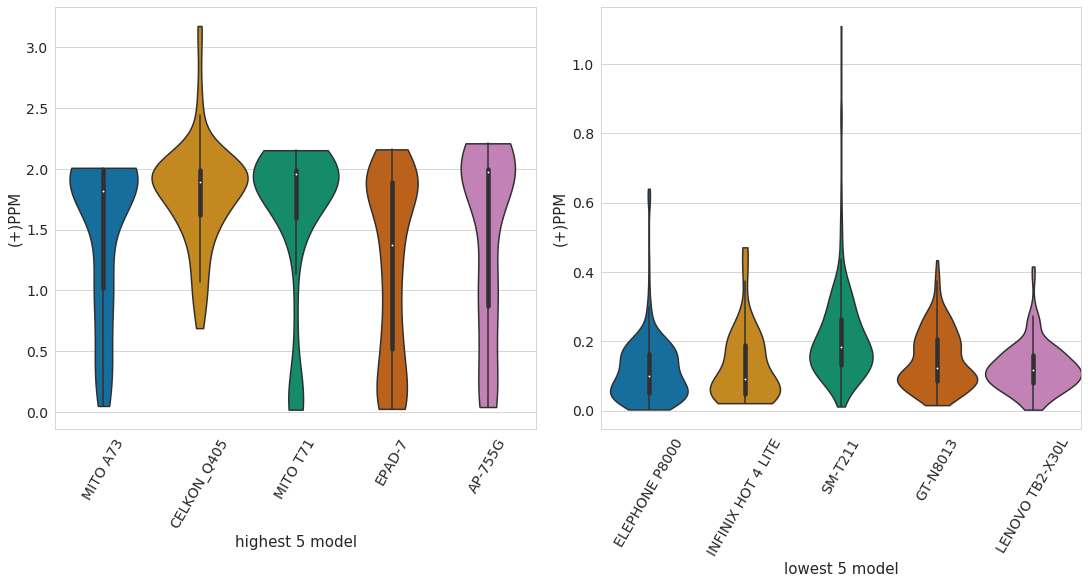

                             model  direction  average_ppm       std  count
2339  HTC DESIRE 526GPLUS DUAL SIM       -1.0     2.234112  1.014838    190
1338                   CELKON_Q405       -1.0     1.987169  0.420201     39
6892                        VEGA-1       -1.0     1.600958  0.520802     67
1720                 EVERCOSS_A74A       -1.0     1.590689  0.892547     35
4120                      MITO T71       -1.0     1.529114  0.776026     56
...                            ...        ...          ...       ...    ...
6774                       U15 PRO       -1.0     0.032933  0.027047     63
7503                ZTE BLADE A522       -1.0     0.031842  0.039017     60
1190                  BQ AQUARIS 5       -1.0     0.022840  0.012963     63
6587                TBOOK 11(E5A6)       -1.0     0.020455  0.004737     53
6449                  SUGAR Y7 MAX       -1.0     0.013864  0.006509     44

[1258 rows x 5 columns]


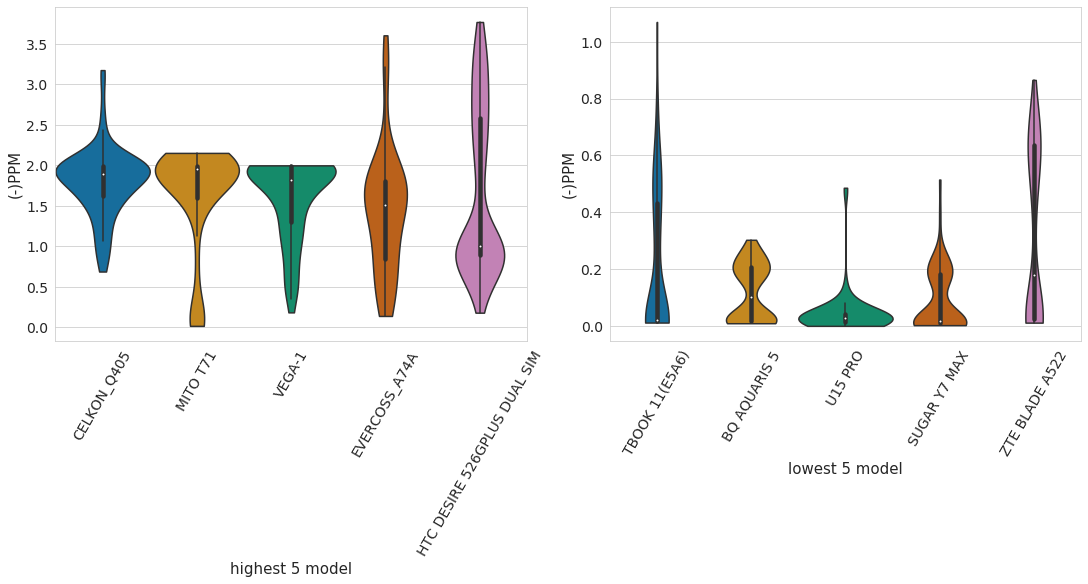

In [17]:
print(dfModelGBPos); 
boxPlotPPMTopBot(df_inner_droppedDup,dfModelGBPos,'ppm','model','(+)PPM','model')
print(dfModelGBNeg);
boxPlotPPMTopBot(df_inner_droppedDup,dfModelGBNeg,'ppm','model','(-)PPM','model')

      manufacturer  direction  average_ppm       std  count
196    CELKON_Q405        1.0     1.617081  0.354479     42
338       EUROSTAR        1.0     1.608783  0.440403    133
1181        VEGA-1        1.0     1.575978  0.479164     72
893   POSITIVO BGH        1.0     1.575368  0.502343     87
103            AS8        1.0     1.571011  0.554217    160
...            ...        ...          ...       ...    ...
283        DIGICEL        1.0     0.264196  0.106227     50
327   ENERGYSISTEM        1.0     0.256444  0.104593     66
936           R50A        1.0     0.249506  0.151276    129
325      ENERGIZER        1.0     0.194335  0.126936     34
461             HP        1.0     0.191686  0.151974     35

[247 rows x 5 columns]


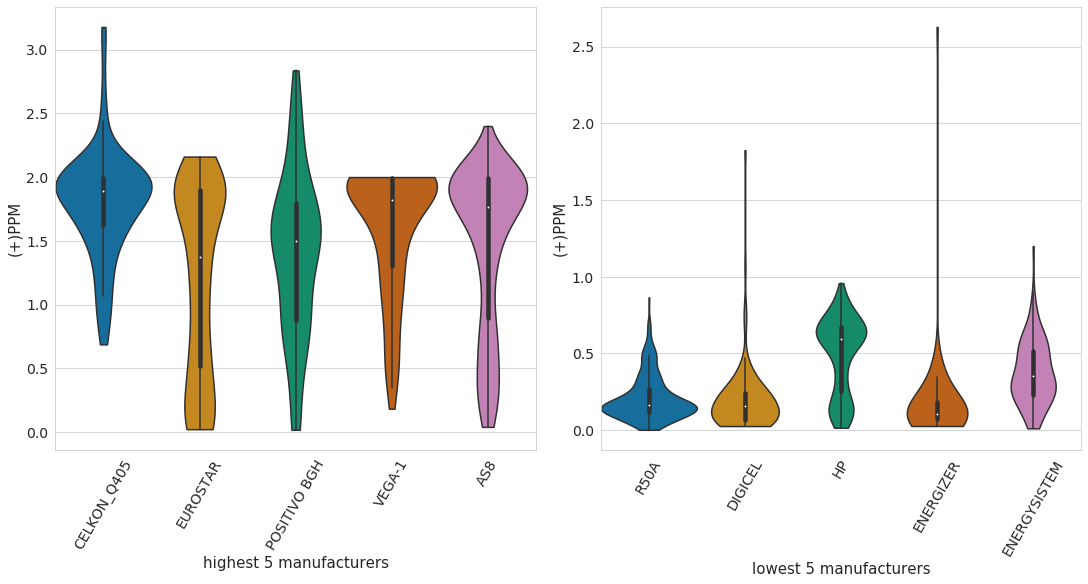

             manufacturer  direction  average_ppm       std  count
195           CELKON_Q405       -1.0     1.987169  0.420201     39
1180               VEGA-1       -1.0     1.600958  0.520802     67
102                   AS8       -1.0     1.327904  0.695195    139
425              GT-N9000       -1.0     1.305943  0.917365     51
901              PRINCESS       -1.0     1.279488  0.772466    112
...                   ...        ...          ...       ...    ...
226                  CMDC       -1.0     0.101931  0.077460     98
408              GIGABYTE       -1.0     0.088568  0.151660     56
988                 SCHOK       -1.0     0.053727  0.082269     63
181   BULLITTGROUPLIMITED       -1.0     0.041494  0.026235    577
1092              TECLAST       -1.0     0.020455  0.004737     53

[260 rows x 5 columns]


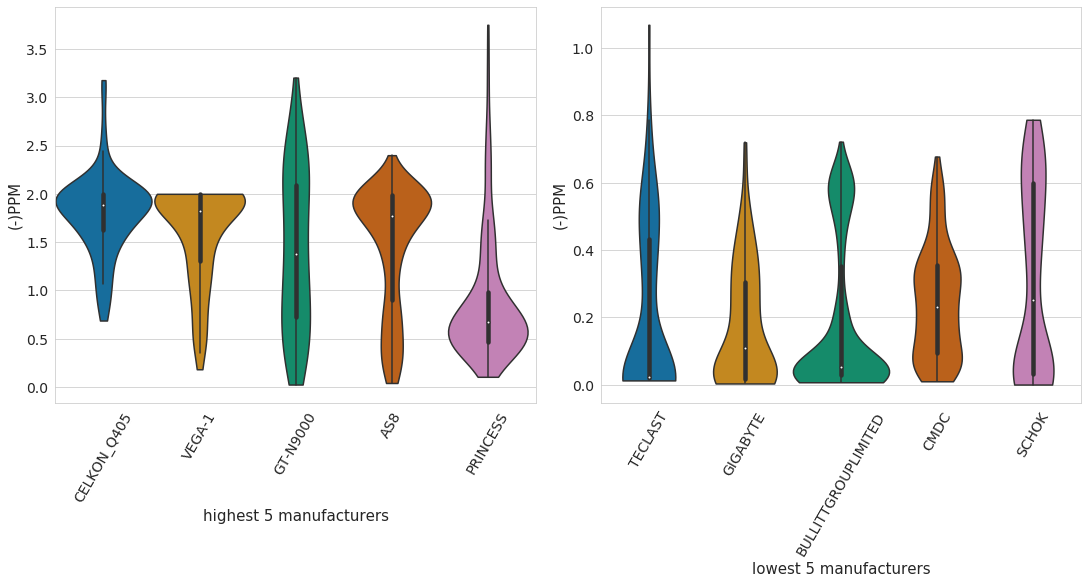

In [18]:
print(dfManufacturerGBPos); 
boxPlotPPMTopBot(df_inner_droppedDup,dfManufacturerGBPos,'ppm','manufacturer','(+)PPM','manufacturers')
print(dfManufacturerGBNeg);
boxPlotPPMTopBot(df_inner_droppedDup,dfManufacturerGBNeg,'ppm','manufacturer','(-)PPM','manufacturers')

             brand  direction  average_ppm       std  count
212    CELKON_Q405        1.0     1.617081  0.354479     42
342         EPAD-7        1.0     1.616750  0.432352    132
1252        VEGA-1        1.0     1.575978  0.479164     72
114            AS8        1.0     1.571011  0.554217    160
482       I-MOBILE        1.0     1.483149  0.442492     65
...            ...        ...          ...       ...    ...
284        DIGICEL        1.0     0.264196  0.106227     50
340   ENERGYSISTEM        1.0     0.256444  0.104593     66
1054         SHARP        1.0     0.247114  0.138660    377
987           R50A        1.0     0.244644  0.149146    125
338      ENERGIZER        1.0     0.194335  0.126936     34

[243 rows x 5 columns]


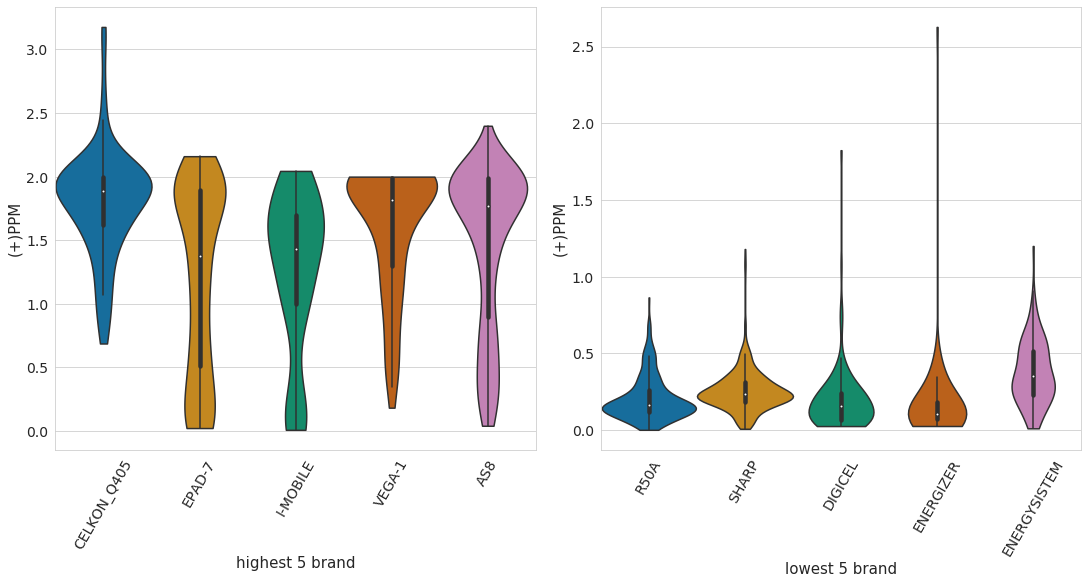

            brand  direction  average_ppm       std  count
211   CELKON_Q405       -1.0     1.987169  0.420201     39
1251       VEGA-1       -1.0     1.600958  0.520802     67
113           AS8       -1.0     1.327904  0.695195    139
952      PRINCESS       -1.0     1.279488  0.772466    112
1085   SPREADTRUM       -1.0     1.264940  0.697785     78
...           ...        ...          ...       ...    ...
572        JCI_JP       -1.0     0.069787  0.058120     38
234   CLASSIC_LTE       -1.0     0.066038  0.117746     53
1032        SCHOK       -1.0     0.053727  0.082269     63
207           CAT       -1.0     0.042793  0.032937    581
1146      TECLAST       -1.0     0.020455  0.004737     53

[260 rows x 5 columns]


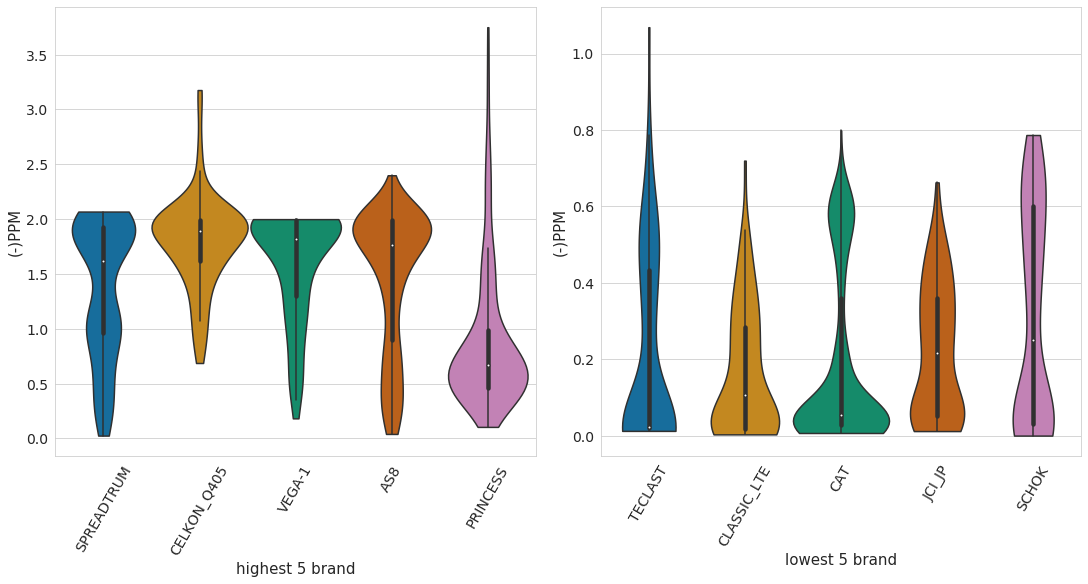

In [19]:
print(dfBrandGBPos); 
boxPlotPPMTopBot(df_inner_droppedDup,dfBrandGBPos,'ppm','brand','(+)PPM','brand')
print(dfBrandGBNeg);
boxPlotPPMTopBot(df_inner_droppedDup,dfBrandGBNeg,'ppm','brand','(-)PPM','brand')


             product  direction  average_ppm       std  count
4493             MID        1.0     1.975070  0.247563     37
6955    V152_JXD_2H2        1.0     1.835263  0.253524     30
6186        SI7067SB        1.0     1.804131  0.278124     36
6948    V130_WKT_0F1        1.0     1.617081  0.354479     42
2034          EPAD-7        1.0     1.616750  0.432352    132
...              ...        ...          ...       ...    ...
4144        LT023GXX        1.0     0.182558  0.135243    118
7398          X557B1        1.0     0.178069  0.085622     32
1997  ELEPHONE P8000        1.0     0.166535  0.055394    105
6588        TB2-X30L        1.0     0.154048  0.058517     60
5090    P4NOTEWIFIUE        1.0     0.125559  0.071723     95

[1233 rows x 5 columns]


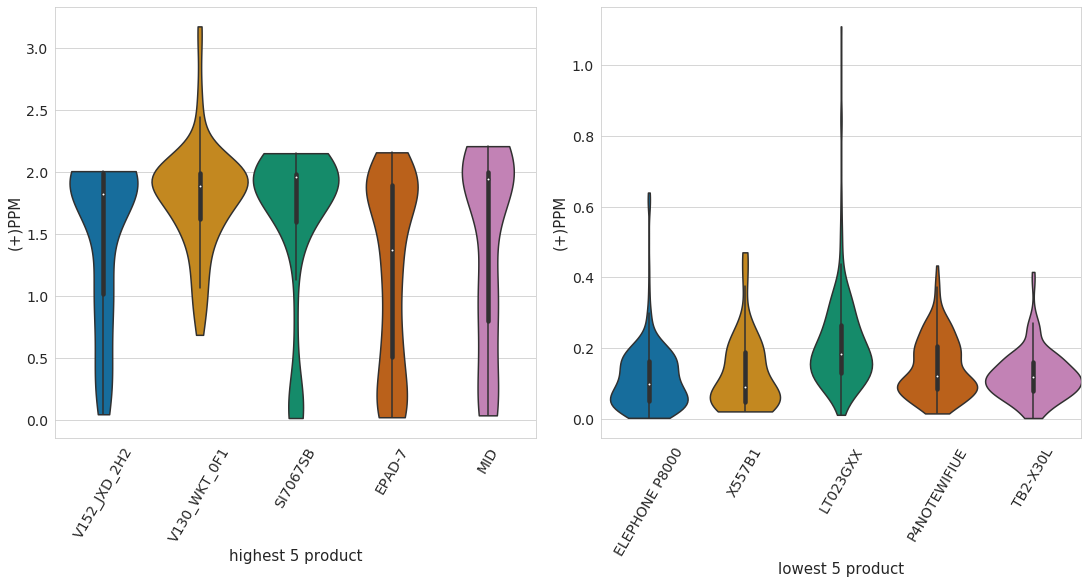

               product  direction  average_ppm       std  count
6947      V130_WKT_0F1       -1.0     1.987169  0.420201     39
6905  V02_HTC_ASIA_WWE       -1.0     1.690637  1.197845    273
7058            VEGA-1       -1.0     1.600958  0.520802     67
6943      V130_TRX_2B1       -1.0     1.590689  0.892547     35
6185          SI7067SB       -1.0     1.529114  0.776026     56
...                ...        ...          ...       ...    ...
5225   P817E53_OEM_VDF       -1.0     0.031842  0.039017     60
1279       BQ_AQUARIS5       -1.0     0.022840  0.012963     63
4141        LT01WIFIUE       -1.0     0.020905  0.012276     38
1499        CHT_CR_MRD       -1.0     0.020455  0.004737     53
7011           V3991AN       -1.0     0.013864  0.006509     44

[1294 rows x 5 columns]


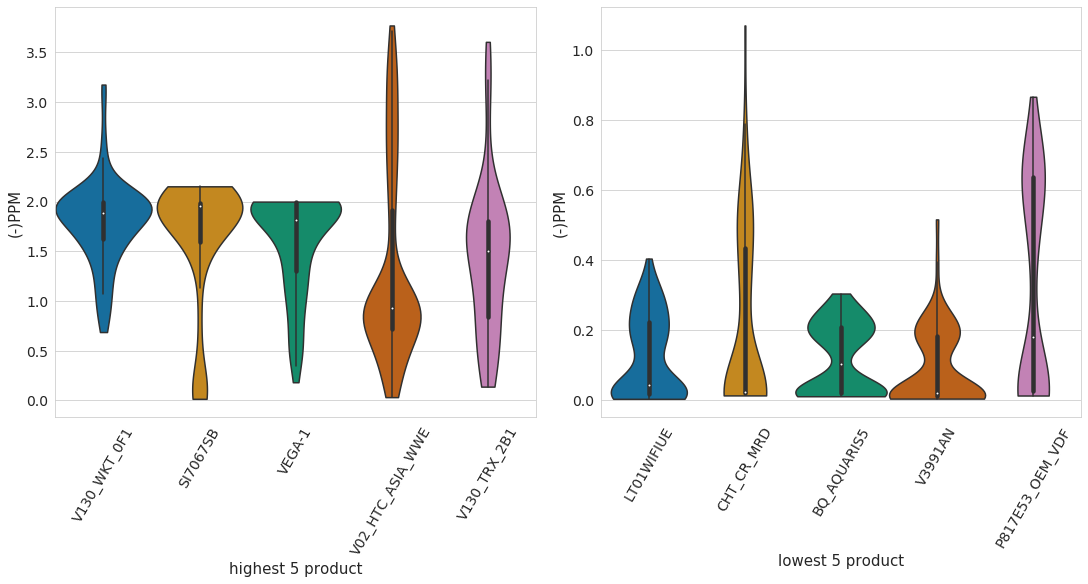

In [20]:
print(dfProductGBPos); 
boxPlotPPMTopBot(df_inner_droppedDup,dfProductGBPos,'ppm','product','(+)PPM','product')
print(dfProductGBNeg);
boxPlotPPMTopBot(df_inner_droppedDup,dfProductGBNeg,'ppm','product','(-)PPM','product')

   os_version  direction  average_ppm       std  count
17      4.4.1        1.0     1.560366  0.708007     38
56      8.0.0        1.0     1.039138  0.353735     39
60        8.1        1.0     0.784049  0.297708     35
31        5.1        1.0     0.761493  0.535559  23328
43        6.1        1.0     0.734578  0.365332    232
45        7.0        1.0     0.698829  0.402697  66211
62      8.1.0        1.0     0.692204  0.394936     74
25        5.0        1.0     0.670627  0.418211   6679
29      5.0.2        1.0     0.661015  0.416994   8548
19      4.4.2        1.0     0.651026  0.430592  16964
3       4.0.4        1.0     0.633155  0.430248     91
52      7.1.2        1.0     0.626305  0.363110   7127
7       4.1.2        1.0     0.608098  0.429772   2959
13        4.3        1.0     0.605738  0.296259   1244
50      7.1.1        1.0     0.597155  0.331302  16493
23      4.4.4        1.0     0.586054  0.377907   6489
36        6.0        1.0     0.584803  0.383156  35572
1       4.

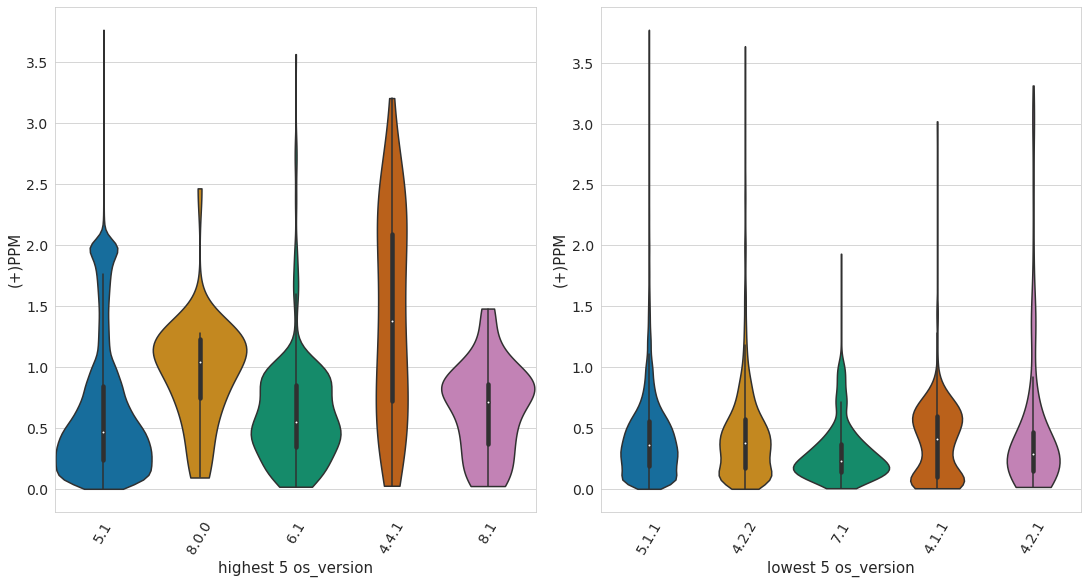

   os_version  direction  average_ppm       std  count
16      4.4.1       -1.0     1.305943  0.917365     51
59        8.1       -1.0     0.563458  0.391578     43
30        5.1       -1.0     0.543368  0.569039  27494
8       4.2.1       -1.0     0.510949  0.737146    226
42        6.1       -1.0     0.510596  0.464515    265
18      4.4.2       -1.0     0.483853  0.540446  21752
2       4.0.4       -1.0     0.465767  0.582339    126
6       4.1.2       -1.0     0.444958  0.468096   3744
24        5.0       -1.0     0.437283  0.497370   8038
63        9.0       -1.0     0.423348  0.295089     33
26      5.0.1       -1.0     0.402726  0.409454   2924
10      4.2.2       -1.0     0.378395  0.481916   4524
28      5.0.2       -1.0     0.368767  0.403489   9365
4       4.1.1       -1.0     0.347638  0.373819    404
35        6.0       -1.0     0.345392  0.393291  42479
12        4.3       -1.0     0.340786  0.376514   1376
22      4.4.4       -1.0     0.336640  0.369871   7524
32      5.

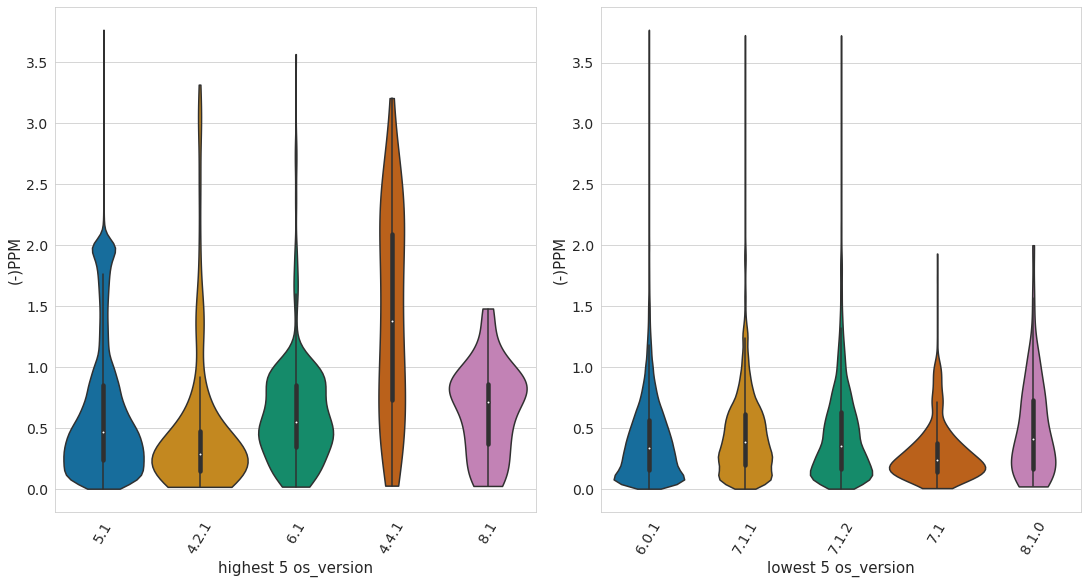

In [21]:
print(dfOsVersionGBPos); 
boxPlotPPMTopBot(df_inner_droppedDup,dfOsVersionGBPos,'ppm','os_version','(+)PPM','os_version')
print(dfOsVersionGBNeg);
boxPlotPPMTopBot(df_inner_droppedDup,dfOsVersionGBNeg,'ppm','os_version','(-)PPM','os_version')

              codename  direction  average_ppm       std  count
14                Oreo        1.0     0.794934  0.384747    157
12              Nougat        1.0     0.673581  0.389638  90121
7             Lollipop        1.0     0.656460  0.445462  60381
5               KitKat        1.0     0.634970  0.420309  23513
1   Ice Cream Sandwich        1.0     0.601249  0.408758    222
9          Marshmallow        1.0     0.574032  0.337901  91256
3           Jelly Bean        1.0     0.568664  0.362739   8613
              codename  direction  average_ppm       std   count
4               KitKat       -1.0     0.447821  0.508926   29351
6             Lollipop       -1.0     0.435281  0.493921   67397
15                 Pie       -1.0     0.423348  0.295089      33
2           Jelly Bean       -1.0     0.399563  0.469350   10282
13                Oreo       -1.0     0.377958  0.344514     118
0   Ice Cream Sandwich       -1.0     0.343710  0.500047     408
8          Marshmallow       -1.0

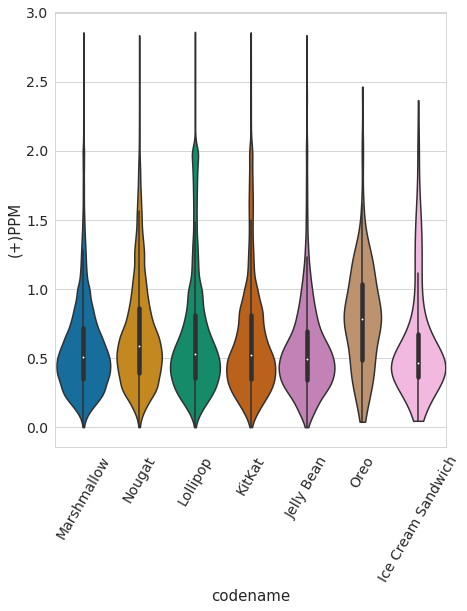

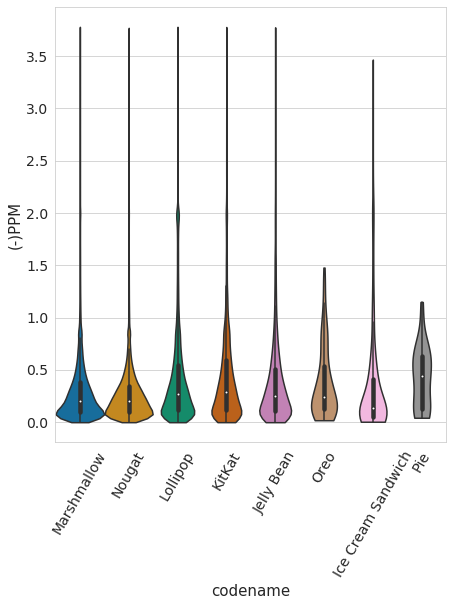

In [55]:
print(dfCodenameGBPos);
dfJoinPos = pd.merge(df_inner_droppedDup.loc[df_inner_droppedDup['direction'] == 1], dfCodenameGBPos, left_on='codename', right_on='codename', how='inner').drop(['average_ppm','std','count','direction_y'], axis=1)
boxPlotPPMAll(dfJoinPos,'ppm','codename','(+)PPM','codename');
print(dfCodenameGBNeg);    
dfJoinNeg = pd.merge(df_inner_droppedDup.loc[df_inner_droppedDup['direction'] == -1], dfCodenameGBNeg, left_on='codename', right_on='codename', how='inner').drop(['average_ppm','std','count','direction_y'], axis=1)
boxPlotPPMAll(dfJoinNeg,'ppm','codename','(-)PPM','codename');